In [40]:
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import astropy.io.fits as pf
import warnings
from astropy.table import Table, vstack
warnings.filterwarnings('ignore')

1. Reading the cascades LRG catalog

In [41]:
diretory = '/global/cfs/cdirs/desi/survey/catalogs/SV1/redshift_comps/cascades/3.1/LRG/'
dataname = 'alltiles_LRGzinfo.fits'
catalog = Table.read(diretory+dataname,hdu='ZBEST')
#zmag = -2.5*np.log10(catalog['FIBERFLUX_Z'])+22.5-1.211*catalog['EBV']

2. Selecting the deep coadds with EFFTIME_dark>3000 & removing LRG targets observed in BGS+MWS observation

In [42]:
search_LRG = np.where((catalog['subset']=='deep') & (catalog['TARGETS']!='BGS+MWS') & (catalog['EFFTIME_DARK']>3000))
catalog_LRG = catalog[search_LRG[0]].copy()
print('Number of deep coadds LRGs:',len(search_LRG[0]))

Number of deep coadds LRGs: 24973


3. Selecting the short exposures coadds with EFFTIME_dark>700 (not deep or all) & removing LRG targets observed in BGS+MWS observation

In [43]:
search_LRG_short = np.where((catalog['subset']!='all') & (catalog['TARGETS']!='BGS+MWS') & (catalog['EFFTIME_DARK']>700))
catalog_LRG_short = catalog[search_LRG_short[0]].copy()
print('Number of short exposures:', len(catalog_LRG_short))

Number of short exposures: 210368


Just checking the EFFTIME_DARK distribution

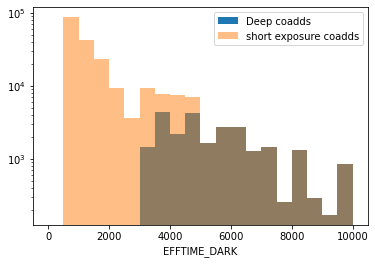

In [44]:
plt.hist(catalog_LRG['EFFTIME_DARK'],bins=20,range=(0,10000),label='Deep coadds')
plt.hist(catalog_LRG_short['EFFTIME_DARK'],bins=20,range=(0,10000),alpha=0.5,label='short exposure coadds')
plt.xlabel('EFFTIME_DARK')
plt.yscale('log')
plt.legend()

4. Creating pandas tables from fit formats

In [45]:
new_catalog_LRG_short = catalog_LRG_short[['TARGETID','Z','subset','TILEID','EFFTIME_DARK','DELTACHI2','ZWARN']].to_pandas()
new_catalog_LRG = catalog_LRG['TARGETID','Z','subset','TILEID','DELTACHI2','EFFTIME_DARK','FIBERFLUX_Z','EBV','ZWARN'].to_pandas()

5. Matching the two catalogs with targetid. The redrock information from the deep coadds has suffixes _deep and short coadds with _short

In [46]:
catalog_LRG_match = new_catalog_LRG.merge(new_catalog_LRG_short,on='TARGETID',how='left',suffixes=("_deep","_short"))

6. Removing same objects but observe in different tiles. and create redshift difference and zfibermag information

In [47]:
final_match_catalog = catalog_LRG_match[catalog_LRG_match['TILEID_deep']==catalog_LRG_match['TILEID_short']]
final_match_catalog['dz']=abs(final_match_catalog['Z_deep']-final_match_catalog['Z_short'])/(1.+final_match_catalog['Z_deep'])
final_match_catalog['zfibermag']=-2.5*np.log10(final_match_catalog['FIBERFLUX_Z'])+22.5-1.211*final_match_catalog['EBV']

7. Selecting targets with non repeatable redshifts.


Selection:
    a. |z_deep-z_short|/(1+z_deep)>0.0033
    
    b. DELTACHI2_deep>40
    
    c. Z_deep<1.4
    
    d. DELTACHI2_short>10
    
    e. zfibermag<21.7
    
    f. ZWARN_deep<=4
    
    g. ZWARN_short<=4
    


In [48]:
dz_not_good_catalog = final_match_catalog[(final_match_catalog['dz']>0.0033) & 
                                          (final_match_catalog['DELTACHI2_deep']>20) & 
                                          (final_match_catalog['Z_deep']<1.4) &
                                          (final_match_catalog['DELTACHI2_short']>10) &
                                          (final_match_catalog['zfibermag']<=21.7) & 
                                          (final_match_catalog['ZWARN_deep']<=4) & 
                                          (final_match_catalog['ZWARN_short']<=4)]

8. Looking at the DELTACHI2_deep distribution with non-repeatable redshifts. What is interesting is that  there are many objects with high Deltachi2 but non-repeatable redshifts.

(1.0, 5.0)

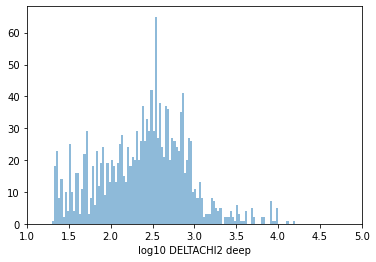

In [49]:
plt.hist(np.log10(dz_not_good_catalog['DELTACHI2_deep']),bins=200,range=(0,5),alpha=0.5)
plt.xlabel('log10 DELTACHI2 deep')
plt.xlim(1,5)
#plt.axvline(2.55)
#plt.axvline(2.525)

In [50]:
#dz_not_good_catalog[(np.log10(dz_not_good_catalog['DELTACHI2_deep'])>2.525) & (np.log10(dz_not_good_catalog['DELTACHI2_deep'])<2.55)]

In [51]:
print('Number of unique targets in the selection:',len(set(dz_not_good_catalog['TARGETID'])))

Number of unique targets in the selection: 945


In [52]:
dz_not_good_catalog

,TARGETID,Z_deep,subset_deep,TILEID_deep,DELTACHI2_deep,EFFTIME_DARK_deep,FIBERFLUX_Z,EBV,ZWARN_deep,Z_short,subset_short,TILEID_short,EFFTIME_DARK_short,DELTACHI2_short,ZWARN_short,dz,zfibermag
146,39627300953659693,1.144237,b'deep',80673,32.697725,3544.111450,3.598842,0.036490,0,1.153200,b'20210206',80673,1765.163574,25.215568,0,0.004180,21.065403
147,39627300953659693,1.144237,b'deep',80673,32.697725,3544.111450,3.598842,0.036490,0,1.498865,b'20210106',80673,889.031998,24.625697,0,0.165387,21.065403
170,39627306632741746,1.071907,b'deep',80673,38.999907,3544.111450,3.978052,0.039553,0,1.177329,b'20210206',80673,1765.163574,48.399835,0,0.050882,20.952927
171,39627306632741746,1.071907,b'deep',80673,38.999907,3544.111450,3.978052,0.039553,0,1.669977,b'20210116',80673,879.886536,34.025930,0,0.288657,20.952927
172,39627306632741746,1.071907,b'deep',80673,38.999907,3544.111450,3.978052,0.039553,0,1.173941,b'20210106',80673,889.031998,12.930748,0,0.049247,20.952927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197611,39633567696815224,1.308183,b'deep',80694,83.146021,3645.791595,3.192952,0.197145,0,1.193570,b'20210109',80694,1651.603180,14.438922,0,0.049655,21.000776
197624,39633567701008493,1.289115,b'deep',80694,193.026811,3645.791595,2.943339,0.247157,0,0.965193,b'20210116',80694,774.684982,64.701088,0,0.141505,21.028593
197625,39633567701008493,1.289115,b'deep',80694,193.026811,3645.791595,2.943339,0.247157,0,0.974355,b'20210109',80694,1651.603180,322.210292,0,0.137503,21.028593
197627,39633567701008493,1.289115,b'deep',80694,193.026811,3645.791595,2.943339,0.247157,0,5.186864,b'20210214',80694,1069.921860,961.263084,0,1.702732,21.028593


9. Another selection

a. DELTACHI2_deep>20

b. Z_deep>1.4

c. zfibermag<21.7

In [53]:
new_catalog_LRG['zfibermag']=-2.5*np.log10(new_catalog_LRG['FIBERFLUX_Z'])+22.5-1.211*new_catalog_LRG['EBV']
high_z_strange_object = new_catalog_LRG[(new_catalog_LRG['DELTACHI2']>20) & 
                                        (new_catalog_LRG['Z']>=1.4) & 
                                        (new_catalog_LRG['zfibermag']<21.7)]

(array([ 0.,  0.,  0.,  0.,  0., 11., 25., 20., 14.,  9., 11.,  7.,  7.,
        11.,  6.,  8.,  7.,  5.,  2.,  2.]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
        2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ]),
 <a list of 20 Patch objects>)

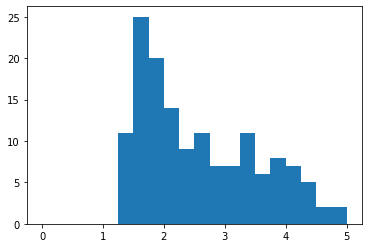

In [54]:
plt.hist(np.log10(high_z_strange_object['DELTACHI2']),bins=20,range=(0,5))


10. Combining the two catalogs and producing a list with 
TILEID, TARGETID, ID_FOR_selection

In [55]:
all_tileid = np.append(dz_not_good_catalog['TILEID_deep'].to_numpy(),high_z_strange_object['TILEID'].to_numpy())
all_targetid = np.append(dz_not_good_catalog['TARGETID'].to_numpy(),high_z_strange_object['TARGETID'].to_numpy())
all_VI_selection = np.append(np.arange(0,len(dz_not_good_catalog['TARGETID'].to_numpy()))*0.,
                             np.arange(0,len(high_z_strange_object['TARGETID'].to_numpy()))*0.+1)

11. Creating an unique target list with no repetition 

In [56]:
TILEID = []
FINAL_TARGETID = []
FINAL_selection = []
unique_tileid = np.array(list(set(all_tileid)))
Number_of_object_per_tile = {}
for i_tile in range(0,len(unique_tileid)):
    if (unique_tileid[i_tile]!=80605) & (unique_tileid[i_tile]!=80609):
        search = np.where(all_tileid==unique_tileid[i_tile])
        tmp_targetid = all_targetid[search[0]]

        unique_targetid = np.array(list(set(tmp_targetid)))
        Number_of_object_per_tile[unique_tileid[i_tile]]=len(unique_targetid)
        for i_td in range(0,len(unique_targetid)):
            TILEID.append(unique_tileid[i_tile])
            FINAL_TARGETID.append(unique_targetid[i_td])
            search_selection = np.where((all_tileid==unique_tileid[i_tile]) & (all_targetid==unique_targetid[i_td]))
            FINAL_selection.append(int(all_VI_selection[search_selection[0][0]]))

In [57]:
print(len(FINAL_selection))
Number_of_object_per_tile

869


{80669: 6,
 80673: 8,
 80675: 5,
 80676: 90,
 80677: 10,
 80678: 75,
 80679: 5,
 80680: 73,
 80681: 5,
 80682: 69,
 80683: 5,
 80684: 28,
 80685: 3,
 80686: 26,
 80688: 41,
 80689: 1,
 80690: 58,
 80692: 35,
 80693: 6,
 80694: 66,
 80699: 5,
 80700: 49,
 80705: 2,
 80707: 4,
 80711: 3,
 80712: 13,
 80607: 100,
 80610: 2,
 80620: 53,
 80622: 22,
 80623: 1}

In [58]:
d = {'TILEID':TILEID,'TARGETID':FINAL_TARGETID,'VI_selection':FINAL_selection}
df = pd.DataFrame(data=d)

In [59]:
df.to_csv('SV_cascades_LRG_VI_target_list.v1.csv',index=False)

In [60]:
new_data = pd.read_csv('SV_cascades_LRG_VI_target_list.v1.csv')

In [61]:
print('TOTAL selected spectra for VI:',len(TILEID))

TOTAL selected spectra for VI: 869
